In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision
import tqdm
import sklearn
import sklearn.datasets
import os
from tensorboardX import SummaryWriter
from torch.utils.data.dataset import random_split
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data_dir = 'data/'

In [3]:
classes = ['healthy', 'Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 
           'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_mosaic_virus', 
          'Tomato_Yellow_Leaf_Curl_Virus']
binary_classes = ['healthy', 'non_healthy']

In [4]:
batch_size = 16

mean = np.array([0.44947562, 0.46524084, 0.40037745])
std = np.array([0.18456618, 0.16353698, 0.20014246])

data_transforms = {
        'train': transforms.Compose([
        #transforms.Pad(padding=40),
        #transforms.RandomAffine(degrees=(0, 0), shear=(20, 20)),
        #transforms.CenterCrop((250, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)]),
        'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)])}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                    data_transforms[x]) for x in ['train', 'test']}

train_dataloader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, 
                                              shuffle=False, num_workers=4)

Non-denormalized image:


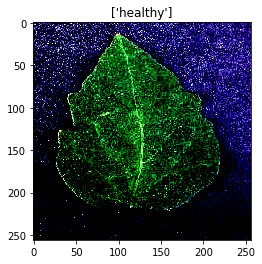

Denormalized image:


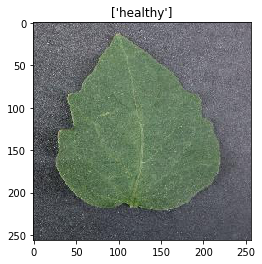

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    print('Non-denormalized image:')
    non_normalized = inp
    non_normalized = np.clip(non_normalized, 0, 1)
    plt.imshow(non_normalized)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
    print('Denormalized image:')
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

for inputs, classes in train_dataloader:
    #os.mkdir('data_augmented')
    #torchvision.utils.save_image(inputs[i], 'data_augmented/a.jpg', nrow=1, normalize=True)
    for i in range(batch_size):
        out = torchvision.utils.make_grid(inputs[i])

        imshow(out, title=[binary_classes[classes[i]]])
        break
    break

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(train_dataloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[0]))
# print labels
print(binary_classes[labels[0]])

healthy


Process Process-11:
Process Process-10:
Process Process-9:
Traceback (most recent call last):
Process Process-12:
  File "/home/mirco/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mirco/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mirco/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/mirco/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/mirco/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/mirco/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mirco/anaconda3/lib

In [12]:
k = 3
splits = []
for i in range(k):
    splits.append('split' + str(i))

train_subtest_dataset_len = len(image_datasets['train'])

splits_size = []
overall_splits_size = 0
for i in range(k - 1):
    overall_splits_size += train_subtest_dataset_len // k
    splits_size.append(train_subtest_dataset_len // k)
splits_size.append(train_subtest_dataset_len - overall_splits_size)

random_splits = random_split(image_datasets['train'], splits_size)
del image_datasets['train']
for i in range(k):
    image_datasets[splits[i]] = random_splits[i]

test_dataloader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size, 
                                              shuffle=True, num_workers=4)

In [9]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # 3 input image channel,
        # 6 output channel,
        # 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation
        self.fc1 = nn.Linear(16 * 61 * 61, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)
        
    def forward(self, x):
        # max pooling over a (2, 2) windows
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [13]:
num_epochs = 1
#num_batches = 8
#num_iterations = 0

#log_dir = 'log/'
#if os.path.exists(log_dir):
#    shutil.rmtree(log_dir)
#writer = SummaryWriter(log_dir)
folds_performances = {}
for validation_set in range(k):
    dataloaders = {}
    datasets = {}
    datasets['train'] = {}
    for split in range(k):
        key = 'split' + str(split)
        if split != validation_set:
            datasets['train'] = torch.utils.data.ConcatDataset([datasets['train'], image_datasets[key]])
        else:
            #validation set
            datasets['val'] = image_datasets[key]  
    
    dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
    
    #creating dataloaders
    dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=batch_size,
                        shuffle=True, num_workers=4) for x in ['train', 'val']}
    
    model = Model()
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    folds_performances[validation_set] = []
    for epoch in tqdm.tqdm(list(range(num_epochs))):  # loop over the dataset multiple epochs
        
        #training and validation part
        for phase in ['train', 'val']:

            if phase == 'train':
                exp_lr_scheduler.step()
                model.train()  # Set to training mode
            else:
                model.eval()  # Set model to evaluate mode

            #running_batch_loss = 0.0
            running_loss = 0.0
            running_corrects = 0

            # iterate over the data
            for inputs, labels in dataloaders[phase]:

                # get the inputs
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad() # zero the gradient buffers

                # forward + loss
                outputs = model(inputs)
                loss = nn.BCEWithLogitsLoss()(outputs.view(-1), labels.float())
                
                if phase == 'train':
                    # backward + optimize
                    loss.backward()
                    optimizer.step() # does the update

                # statistics
                #running_batch_loss += loss.data.item()
                running_loss += loss.data.item() * inputs.size(0)
                preds = torch.round(torch.sigmoid(outputs))
                
                running_corrects += torch.sum(preds.view(-1) == labels.data.float())
            
                """if i % num_batches == num_batches - 1:
                    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_batch_loss / num_batches))
                    num_iterations += i
                    #writer.add_scalar(phase + '/loss', running_loss, num_iterations)
                    running_batch_loss = 0.0"""
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.data.item() / dataset_sizes[phase]
            print('Validation fold #{} - {} Loss: {:.4f} Acc: {:.4f}'.format(validation_set, phase, epoch_loss, epoch_acc))
        folds_performances[validation_set].append(epoch_acc)
            
print('Finished Training.')

  0%|          | 0/1 [00:00<?, ?it/s]Process Process-15:
Traceback (most recent call last):
Process Process-14:
Process Process-13:
Process Process-16:
Traceback (most recent call last):
  File "/home/mirco/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/mirco/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mirco/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mirco/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mirco/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/mirco/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/mirco/anaco

KeyboardInterrupt: 

In [ ]:
for i in range(0, k):
    print(str(i) + ": " + str(folds_performances[i]))

In [ ]:
# Statistical approach
total_epoch_performace = [0] * num_epochs
for epoch in range(0, num_epochs):
    for i in range (0, k):
        total_epoch_performace[epoch] += folds_performances[i][epoch]
print('Statistical best number of epochs: {}'.format(total_epoch_performace.index(max(total_epoch_performace))))

# Mitchell approach
total_max_performance = [0] * k
for i in folds_performances:
    total_max_performance[i] = folds_performances[i].index(max(folds_performances[i]))
print('Mitchell average best number of epochs: {}'.format(sum(total_max_performance) / k))

Non-denormalized image:


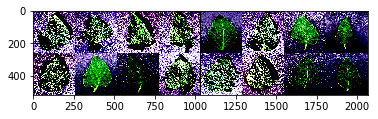

Denormalized image:


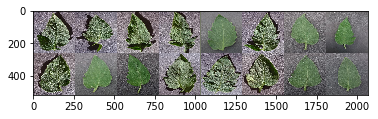

GroundTruth:  healthy healthy healthy healthy healthy healthy healthy healthy healthy healthy healthy healthy healthy healthy healthy healthy


In [7]:
test_dataloader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size, 
                                              shuffle=False, num_workers=4)
dataiter = iter(test_dataloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % binary_classes[labels[j]] for j in range(16)))

In [14]:
#if GPU_MODE:
#    outputs = model(Variable(images).cuda())
#else:
#    outputs = model(Variable(images))
outputs = model(images)
outputs = outputs.to(device)

_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % binary_classes[predicted.cpu()[j]]
                              for j in range(16)))

Predicted:  healthy healthy healthy healthy healthy healthy healthy healthy healthy healthy healthy healthy healthy healthy healthy healthy


In [17]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = model(images)
        outputs = outputs.to(device)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 51 %


In [20]:
class_correct = list(0. for i in range(2)) #2 for binary classes
class_total = list(0. for i in range(2)) #2 for binary classes
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = model(images)
        outputs = outputs.to(device)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(2): #2 for binary classes
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(2): #2 for binary classes
    print('Accuracy of %5s : %2d %%' % (binary_classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of healthy : 100 %
Accuracy of non_healthy :  0 %
